# Generating a Synthetic Dataset and Learning a Fair Classifier

## Notebook Objectives

1. **Causal Graph** 
  1. Define a causal graph that corresponds to a hypothetical binary classification task.

2. **Data Generating Process** 
  1. Specify probability distributions and corresponding parameters for a data generating process that corresponds to the graph.
  2. Identify "sensitive" variables (in the context of fairness).

3. **Generate unfair dataset (and show it's unfair)**
  1. Intervene on the sensitive variable (A)
  2. Hold non-descendents of sensitive variable constant (Q)
  3. Re-generate other features (D, M) and target (Y) using structural equations.

4. **Learn a fair algorithm from this dataset** 
  1. Logistic regression using only Q

5. **Generate another dataset using your new (fair) hiring rule.**
  1. Can even use same noise terms if you want.

6. **Show that this new algorithm is fair**
  1. Use same counterfactual fairness equation

7. **Perform final sanity checks**

8. **Future directions (outside of this notebook):** 
  1. Apply the same procedure to a real dataset that you've applied a causal model to
  2.you won't be able to show it's counterfactually fair, but as long as assumptions of your causal model are correct, you should have a fair algortihm (fairness depends on who's right about how the world works)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from graphviz import Digraph
import scipy.stats as stats
from scipy.stats import bernoulli
import math

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 1. Causal Graph

Consider a hypothetical situation where candidates are applying for a job in a warehouse that requires, among other qualifications, physical strength and good communication. Suppose our goal is to predict whether each candidate should be hired ***(Y)***, and we have the following observable variables at our disposal:
1. **(Q)**: Whether they are generally qualified for the job (e.g. including, but not limited to, whether they have relevant employment experience)
2. **(D)**: The number of children a candidate has (which could be influenced by unobserved features, like communication skills, which are assets to the job)
3. **(M)**: A measure of the candidate's physical strength (an asset to the job)
4. **(A)**: The candidate's gender (a sensitive variable in that it should not influence employment outcome directly)

**A note on sensitive variables and paths:** 
1. There are several accepted quantitative definitions for a "fair classifier" in the literature, but generally speaking, a fair classifier should not allow a sensitive variable to directly influence classification.
2. Beyond the scope of this notebook is a concept called "path-specific fairness." The idea here is that a variable may be sensitive only via certain causal pathways. In the example below, the influence of gender on an applicant's number of children would be unfair, but the influence of gender on physical strength would not. These unfair paths are indicated using red edges in the diagram below:  

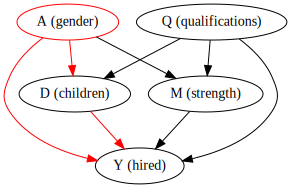

In [2]:
g6 = Digraph(comment='causal graph - synthetic dataset')

g6.node('A', label='A (gender)', color='red')
g6.node('D', label='D (children)')
g6.node('M', label='M (strength)')
g6.node('Q', label='Q (qualifications)')
g6.node('Y', label='Y (hired)')

g6.edge('A', 'D', color='red')
g6.edge('A', 'M')
g6.edge('A', 'Y', color='red')
g6.edge('D', 'Y', color='red')
g6.edge('M', 'Y')
g6.edge('Q', 'D')
g6.edge('Q', 'M')
g6.edge('Q', 'Y')

g6

## 2. Data Generating Process

### 2.1. Data Generating Process

We specify the following probability distributions and parameters for each node in the causal graph above:<br><br>

$A = U_A;
\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,
U_A ∼ Bern(0.6)$ <br>

$Q = \left\lfloor{U_Q}\right\rfloor;
\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,
U_Q ∼ N(2,5)$ <br>

$D = A + \left\lfloor{0.5 * Q * U_D}\right\rfloor;
\,\,\,\,\,\,\,
U_D∼ TrN(2,1,0.1,3,0)$ <br>

$M = 3A + 0.4 * Q * U_M;
\,\,\,\,\,\,\,
U_M∼ TrN(3,4,0.1,3,0)$ <br><br>

$Y = h(A,Q,D,M);$

$h(A,Q,D,M) \propto (0.1*A) + (0.1*Q) + (0.17*D) + (0.3*M)$


<br><br>  where  h() is a logistic regression classifier and TrN are truncated normal distributions. Note that this is the exact data generation process specified in Chikahara et. al., [here](https://arxiv.org/pdf/2002.06746.pdf).<br><br>

**NOTE:** We'll have to make one key modification to the DGP: we need to make Q, the only non-descendent of A, discrete in order to compute countefactual fairness:

$P(\hat{Y}_{A=a} | Q=q, A=a) = P(\hat{Y}_{A=a'} | Q=q, A=a) $

## 3. Generate unfair dataset (and show it's unfair)

#### 3.1. Implementation

We plan our implementation so that we can generate two datasets:  
1. **Factual Dataset:** this is generated exactly as defined by the data generating process above
2. **Counterfactual Dataset:** this is generated by intervening on the sensitive variable, gender. In this case:
  1. Because Q is not a descendant of A, it will take on the exact same values as the factual dataset
  2. D and M are descendents of A, so they will take on new values following intervention, as new values of A are propagated through the structural equations.

#### 3.2. Generate all noise terms (U variables), store them in a dataframe 

In [3]:


def build_noise_df(size=None):
  """
  This funtion constructs a dataframe containing distributions for three noise terms which will be 
  re-used over the course of our experimentation (for factual and counter-factual data generation).
  Inputs: Optionally specify the size of the synthetic dataset (default is 1k observations)
  Output: Dataframe with three columns (U_Q = normal, U_D and U_M truncated normals)
  """

  if size:
    n = size
  else:
    n = 1000

  # Q (general qualifications)
  U_Q = np.random.normal(2, 5, n)

  # D (number of children)
  lower_d, upper_d = 0.1, 3
  mu_d, sigma_d = 2, 1
  X_d = stats.truncnorm((lower_d - mu_d) / sigma_d, (upper_d - mu_d) / sigma_d, loc=mu_d, scale=sigma_d)
  U_D = X_d.rvs(n)

  # M (physical strength)
  lower_m, upper_m = 0.1, 3
  mu_m, sigma_m = 3, 2
  X_m = stats.truncnorm((lower_m - mu_m) / sigma_m, (upper_m - mu_m) / sigma_m, loc=mu_m, scale=sigma_m)
  U_M = X_m.rvs(n)


  return pd.DataFrame({'U_Q': U_Q, 'U_D': U_D, 'U_M': U_M})


In [4]:
error_df = build_noise_df()
error_df.head(10)

,U_Q,U_D,U_M
0,3.089875,1.523484,2.453379
1,5.556211,0.128336,2.701451
2,3.738439,2.438404,1.358135
3,5.523573,1.149790,2.181216
4,1.493465,2.311792,2.121589
5,5.653269,1.282053,1.650576
6,3.618288,2.876643,1.900848
7,5.040861,2.569879,2.647013
8,4.683823,2.159074,2.449809
9,11.147715,1.426921,0.315756


#### 3.3. On the same df, generate Q and A variables (make sure Q is discretized BEFORE propagating down to the next node)

In [5]:
def fac_counterfac_gen(error_terms_df, counterfac=False):
  """
  Inputs: 
    - Dataframe containing noise terms 
    - (optional) Boolean flag indicating whether to generate factual or counterfactual data
  Output: Dataframe containing all observable variables for this DGP (Q, A, M, D, Y)
  """
  
  # Parameters
  p = 0.6   
  n = error_terms_df.shape[0]

  # Q (qualifications); this variable is discretized
  Q_pre = np.floor(error_terms_df['U_Q'])
  Q = np.where(Q_pre <= np.quantile(Q_pre, 0.5), 1, 2)

  # A (gender) 
  if counterfac==True:
    A = np.ones(n)
  else:
    A = bernoulli.rvs(p=p, size=n) + 1

  # D (children)
  D = -1 * A + np.floor(0.7 * Q * error_terms_df['U_D'])

  # M (physical strength)
  M = A + (0.6 * Q * error_terms_df['U_M'])


  # Define sigmoid helper method
  sigmoid = lambda x: 1/(1+ math.exp(-x))

  # Evaluate Y
  Y = np.zeros(n)
  for i in range(n):
      Y[i] = sigmoid(-1 + 0.1*A[i] + 0.1*Q[i] + .17*D[i] + .3*M[i]) >= 0.5  # Note: added 0.1 coefficient in front of Q; M and D will be sources of stochastisity
  
  # Return dataframe
  df_out = pd.DataFrame({'A': A, 'D': D, 'M': M ,'Q': Q, 'Y':Y})

  return df_out





#### 3.4. Generate two dfs:
1. observations (factual) <-- pass all U, Q, and A through graph
2. counterfactuals <-- in df of error terms, set value of A to A' value ("hold everything constant" by fixing the error terms), then propagate new data through the graph (same as above). If gender was not a root node, be careful not to propagate any other data INTO gender 

In [6]:
# Factual (no intervention):

no_intervention = fac_counterfac_gen(error_df)
# no_intervention.head(10)

# Optionally write to CSV:
# no_intervention.to_csv('no_intervention.csv', index= False)

In [7]:
# Counterfactual (intervention, i.e. set A equal to 1, which corresponds to male):

intervention = fac_counterfac_gen(error_df, counterfac=True)
# intervention.head(10)

# Optionally write to CSV:
# intervention.to_csv('intervantion.csv', index = False)

#### 3.5. Subset at all levels of Q and A to evaluate counterfactual fairness

In [19]:
def stratifed_hiring_rates(df):
  A_Q_strat = df.groupby(['Q','A'])['Y'].agg(['sum','count'])
  A_Q_strat['rate'] = 100.0 * A_Q_strat['sum'] / A_Q_strat['count']
  print("Hiring rate \n", A_Q_strat['rate'])
  return


print("Hiring rate by gender and qualifications: \n\nFemale: A=1; Male: A=2 \nUnqualified: Q=1: Qualified: Q=2:")
print("\n\nFACTUAL")
stratifed_hiring_rates(no_intervention)
print("\n\nCOUNTERFACTUAL")
stratifed_hiring_rates(intervention)

Hiring rate by gender and qualifications: 

Female: A=1; Male: A=2 
Unqualified: Q=1: Qualified: Q=2:


FACTUAL
Hiring rate 
 Q  A
1  1     9.292035
   2    50.442478
2  1    88.690476
   2    97.752809
Name: rate, dtype: float64


COUNTERFACTUAL
Hiring rate 
 Q  A  
1  1.0     8.672566
2  1.0    88.735632
Name: rate, dtype: float64


<br><br>
## 4. Learn Fair Classifier
<br>
As demonstrated above, employment is NOT fair under the counterfactual fairness definition:

$ P(Y_{A=a} = 1 | Q) \neq  P(Y_{A=a'} = 1 | Q) $

Under intervention to set males --> female, males are hired at a higher rate (especially when not qualified).

<br>

Recall, a predictor is considered counterfactually fair if:

$ P(\hat{Y}_{A<-a}(U) = y | Q=q, A=a) =  P(\hat{Y}_{A<-a'}(U) = y | Q=q, A=a) $ 

LHS interpretation: For a factual individual, probability your classifier gets the label correct.<br>
RHS interpretation: For a counterfactual individual, probability your classifier gets the label correct.

In [9]:
# Logistic regression using only Q (because this is the only non-descendent of A, a condition required for a fair classifier per Kusner et. al.)

from sklearn.linear_model import LogisticRegression

# Separate features and labels
X = pd.DataFrame(no_intervention['Q'])
y = no_intervention['Y']

# Train logistic regression
clf = LogisticRegression(random_state=0).fit(X, y)

# Print accuracy and regression coefficient
print("Fair predictor accuracy: ", clf.score(X, y))
Q_reg_coef = clf.coef_[[0]]
reg_intercept = clf.intercept_[[0]]
print("Logistic regression coefficient on Q: ", Q_reg_coef)
print("Logistic regression intercept: ", reg_intercept)

Fair predictor accuracy:  0.783
Logistic regression coefficient on Q:  [[3.30322289]]
Logistic regression intercept:  [-3.94135146]


In [10]:
clf.intercept_

array([-3.94135146])

In [11]:
# Create a dataframe containing predictions, labels, and original (no intervention) data
results = no_intervention.copy()
results['fair_pred'] = clf.predict(X)
results['match'] = np.where(results['Y']==results['fair_pred'], 1, 0)

grouped = results.groupby(['A','Y'])['match'].agg(['sum','count'])
grouped['accuracy'] = 100.0 * grouped['sum'] / grouped['count']

grouped

sum  count   accuracy
A Y                         
1 0.0  205    224  91.517857
  1.0  149    170  87.647059
2 0.0  168    174  96.551724
  1.0  261    432  60.416667

Interesting. The classifier works well for women, well for men who are not hired, but poorly for men who are hired.

<br><br>
## 5. Generate another dataset using your new (fair) hiring rule.


In [12]:
def fair_fac_counterfac_gen(error_terms_df, fair_Q_coefficient, fair_intercept, counterfac=False):
  """
  Inputs: 
    - Dataframe containing noise terms 
    - (optional) Boolean flag indicating whether to generate factual or counterfactual data
  Output: Dataframe containing all observable variables for this DGP (Q, A, M, D, Y)
  """
  
  # Parameters
  p = 0.6   
  n = error_terms_df.shape[0]

  # Q (qualifications); this variable is discretized
  Q_pre = np.floor(error_terms_df['U_Q'])
  Q = np.where(Q_pre <= np.quantile(Q_pre, 0.5), 1, 2)

  # A (gender) 
  if counterfac==True:
    A = np.ones(n)
  else:
    A = bernoulli.rvs(p=p, size=n) + 1

  # D (children)
  D = -1 * A + np.floor(0.7 * Q * error_terms_df['U_D'])

  # M (physical strength)
  M = A + (0.6 * Q * error_terms_df['U_M'])


  # Define sigmoid helper method
  sigmoid = lambda x: 1/(1+ math.exp(-x))

  # Evaluate Y
  Y = np.zeros(n)
  for i in range(n):
      Y[i] = sigmoid(fair_intercept + fair_Q_coefficient * Q[i]) >= 0.5  # Note: added 0.1 coefficient in front of Q; M and D will be sources of stochastisity
  
  # Return dataframe
  df_out = pd.DataFrame({'A': A, 'D': D, 'M': M ,'Q': Q, 'Y':Y})

  return df_out

In [13]:
# 1. We will even re-use the same noise terms as previously

fair_fac = fair_fac_counterfac_gen(error_df, fair_Q_coefficient=Q_reg_coef, fair_intercept=reg_intercept, counterfac=False)
fair_counterfac = fair_fac_counterfac_gen(error_df, fair_Q_coefficient=Q_reg_coef, fair_intercept=reg_intercept, counterfac=True)

fair_fac.head()


# 2. DON'T re-use the same noise terms as previously

error_df2 = build_noise_df()
fair_fac = fair_fac_counterfac_gen(error_df2, fair_Q_coefficient=Q_reg_coef, fair_intercept=reg_intercept, counterfac=False)
fair_counterfac = fair_fac_counterfac_gen(error_df2, fair_Q_coefficient=Q_reg_coef, fair_intercept=reg_intercept, counterfac=True)

<br><br>
## 6. Show that this new algorithm is fair (same CF equation)

In [14]:
print("Hiring rate by gender and qualifications: \n\nFemale: A=1; Male: A=2 \nUnqualified: Q=1: Qualified: Q=2:")
print("\n\nFACTUAL")
stratifed_hiring_rates(fair_fac)
print("\n\nCOUNTERFACTUAL (male changed to female)")
stratifed_hiring_rates(fair_counterfac)


Hiring rate by gender and qualifications: 

Female: A=1; Male: A=2 
Unqualified: Q=1: Qualified: Q=2:


FACTUAL
Hiring rate 
 Q  A
1  1      0.0
   2      0.0
2  1    100.0
   2    100.0
Name: rate, dtype: float64


COUNTERFACTUAL (male changed to female)
Hiring rate 
 Q  A  
1  1.0      0.0
2  1.0    100.0
Name: rate, dtype: float64


<br><br>
## 7. Final sanity checks:
1. anytime hiring depends only on Q, both sides should be equal
2. anytime hiring depends directly on A (or on descendents of A), two sides are not equal

<br><br>
## 8. then, apply the same procedure to a real dataset that you've applied a causal model to
  1. you won't be able to show it's counterfactually fair, but as long as assumptions of your causal model are correct, you should have a fair algortihm (fairness depends on who's right about how the world works)

<br><br><br><br><br><br><br><br>

## Scatch work, visualization, etc

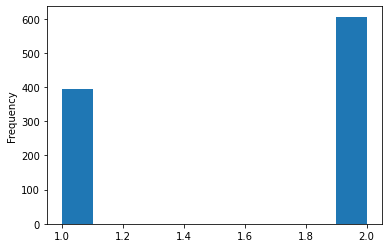

In [15]:
no_intervention['A'].plot(kind='hist')

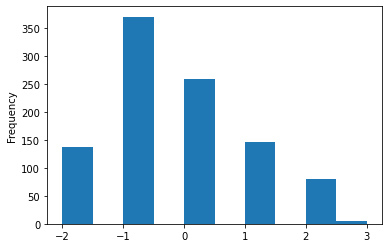

In [16]:
no_intervention['D'].plot(kind='hist')

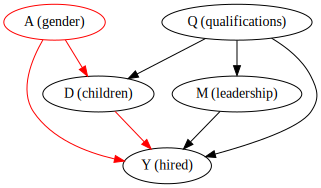

In [17]:
# A potentially simpler causal graph: 

g7 = Digraph(comment='causal graph - synthetic dataset')

g7.node('A', label='A (gender)', color='red')
g7.node('D', label='D (children)')
g7.node('M', label='M (leadership)')
g7.node('Q', label='Q (qualifications)')
g7.node('Y', label='Y (hired)')

g7.edge('A', 'D', color='red')
g7.edge('A', 'Y', color='red')
g7.edge('D', 'Y', color='red')
g7.edge('M', 'Y')
g7.edge('Q', 'D')
g7.edge('Q', 'M')
g7.edge('Q', 'Y')

g7